In [142]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

import warnings
warnings.filterwarnings("ignore")

In [143]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

## Lag Plots to visually check for stationarity

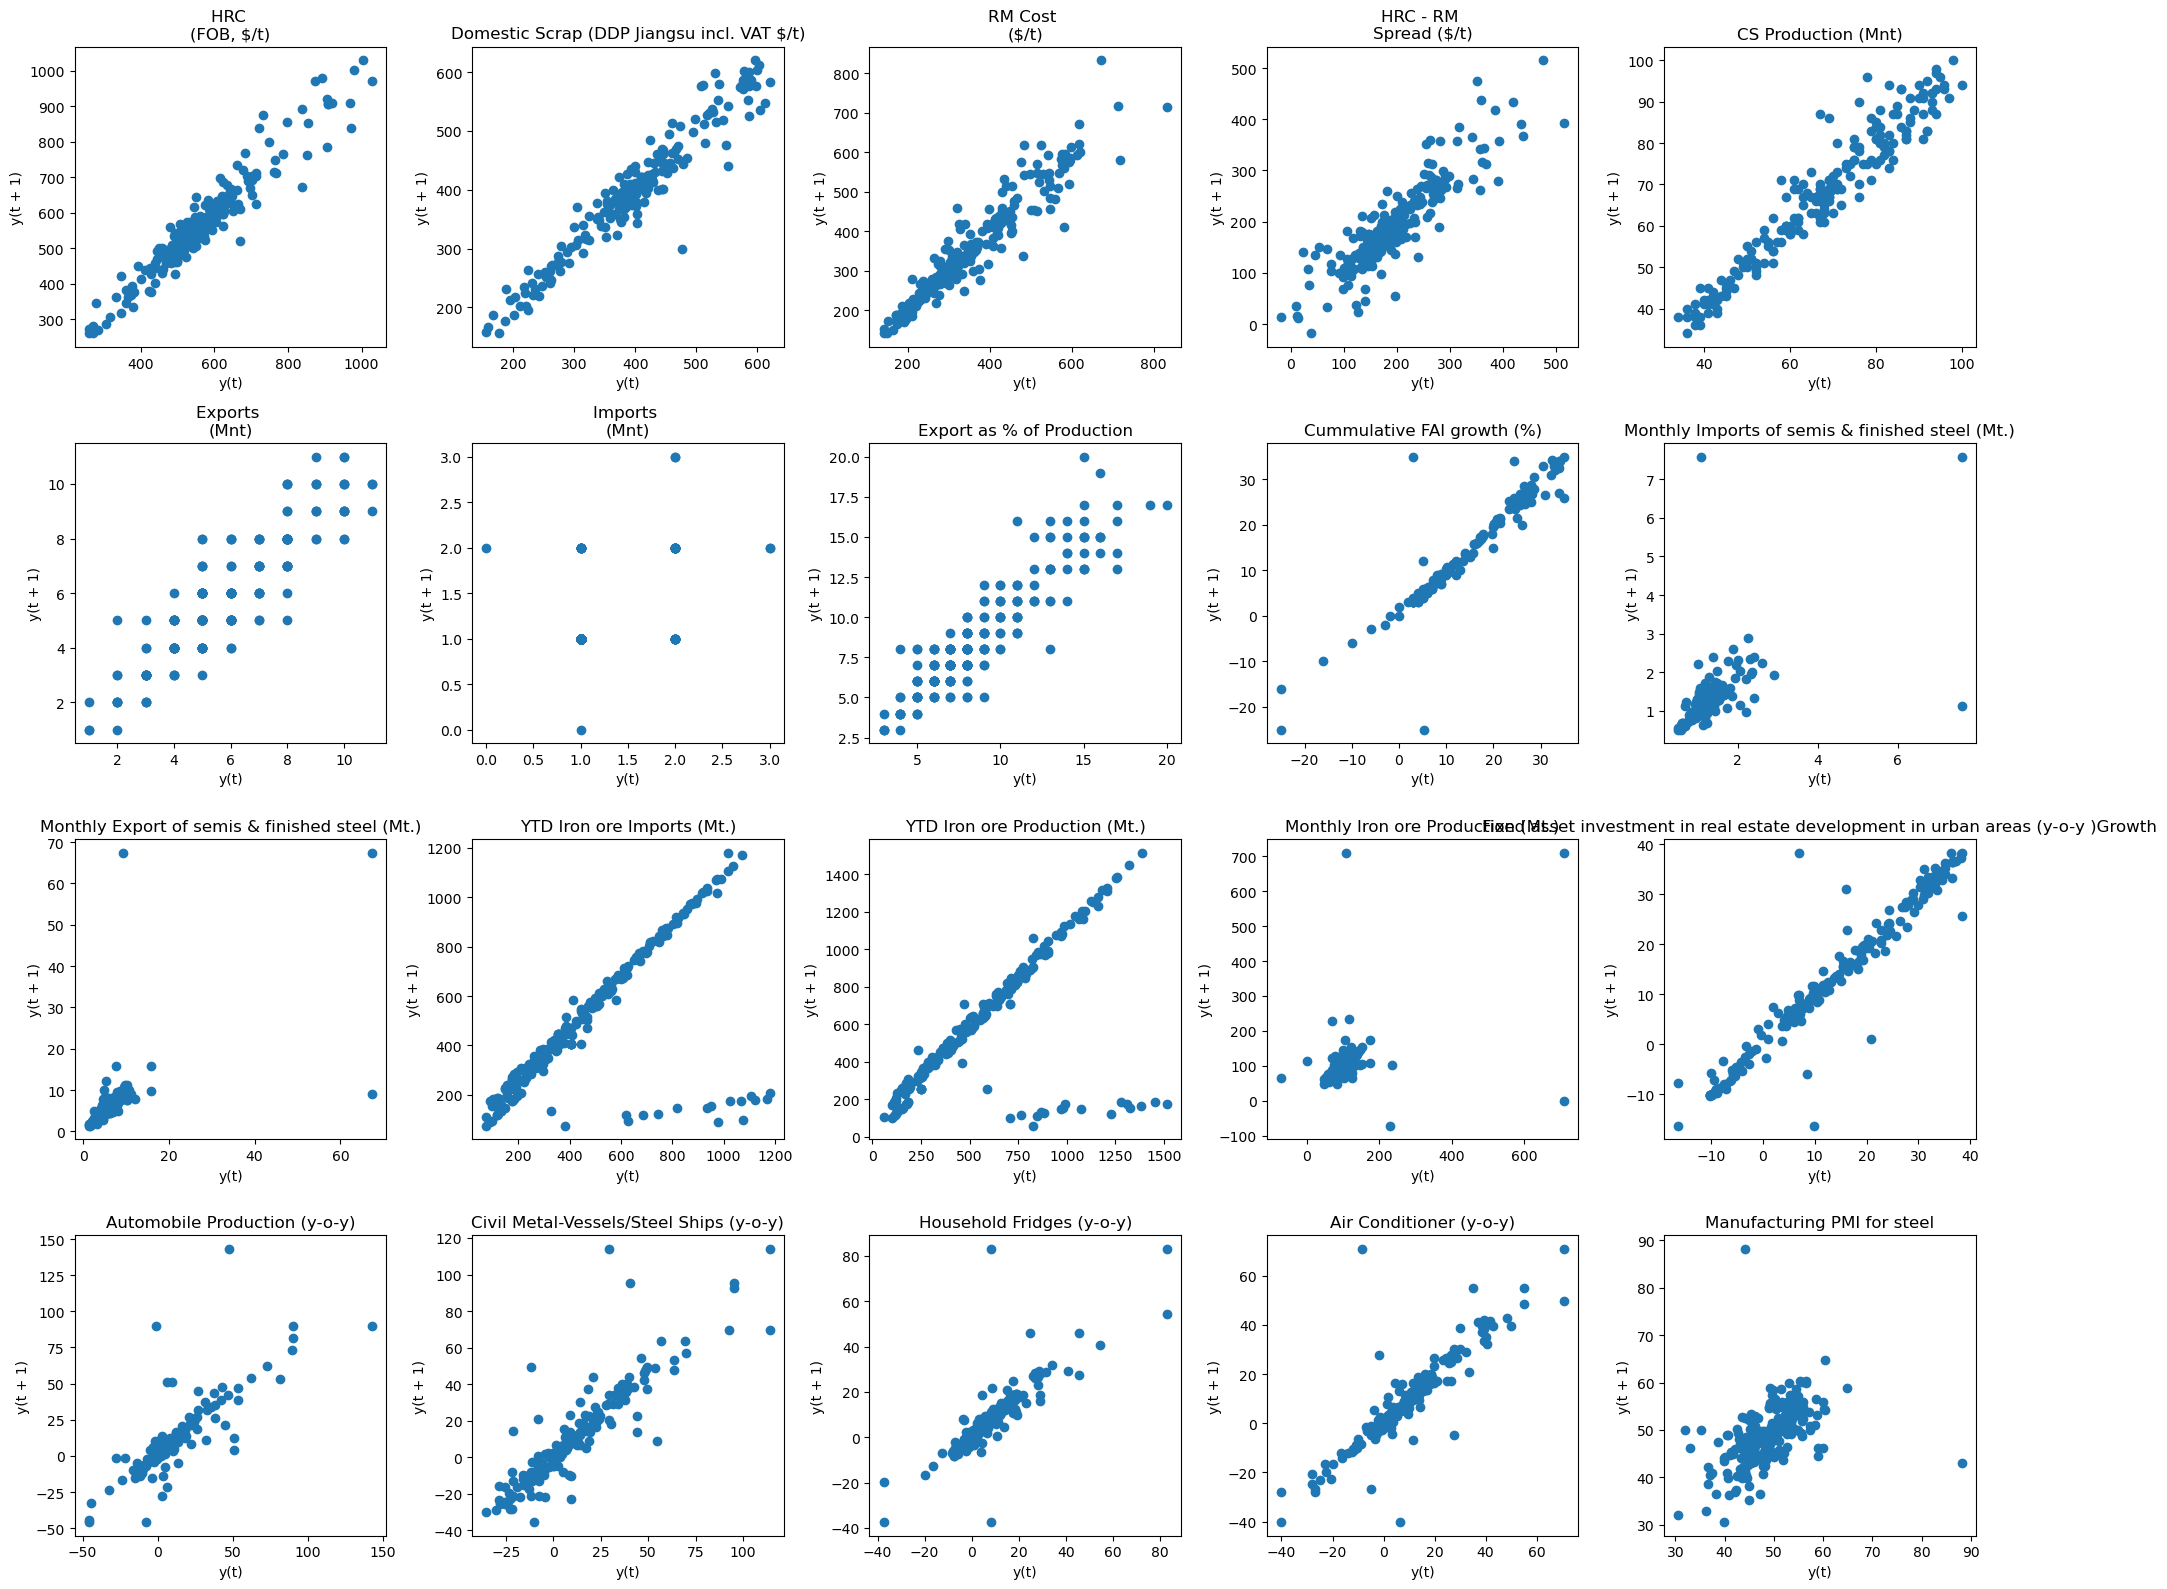

In [144]:
# Columns to plot
factors = [col for col in df.columns if col not in ['Unnamed: 0', 'Month_Dt', 'Month', 'Year']]

n_cols = 5
n_rows = -(-len(factors) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(factors):
    lag_plot(df[col], lag=1, ax=axes[i])
    axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()


## ADF Test for Stationarity

In [145]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

def adf_results(df):
    adf_df = adf_test(df)
    stationary_cols = adf_df.columns[adf_df.loc['p-value'] < 0.05]
    non_stationary_cols = adf_df.columns[adf_df.loc['p-value'] >= 0.05]

    return stationary_cols, non_stationary_cols

In [146]:
# Columns to run ADF test on
factors = [col for col in df.columns if col not in ['Unnamed: 0', 'Month_Dt', 'Month', 'Year']]
# df with only the factors
df_factors = df[factors]

# Conduct ADF test
stationary_adf, non_stationary_adf = adf_results(df_factors)

results_df_adf = pd.DataFrame({
    '': ['Name', 'Number of columns'],
    'Stationary Columns': [stationary_adf, len(stationary_adf)],
    'Non-Stationary Columns': [non_stationary_adf, len(non_stationary_adf)]
})
results_df_adf.style

,,Stationary Columns,Non-Stationary Columns
0,Name,"Index(['HRC \n(FOB, $/t)', 'RM Cost \n($/t)', 'HRC - RM \nSpread ($/t)', 'Imports \n(Mnt)', 'Export as % of Production', 'Monthly Imports of semis & finished steel (Mt.)', 'Monthly Export of semis & finished steel (Mt.)', 'Monthly Iron ore Production (Mt.)', 'Automobile Production (y-o-y)', 'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)', 'Manufacturing PMI for steel'], dtype='object')","Index(['Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 'CS Production (Mnt)', 'Exports \n(Mnt)', 'Cummulative FAI growth (%)', 'YTD Iron ore Imports (Mt.)', 'YTD Iron ore Production (Mt.)', 'Fixed asset investment in real estate development in urban areas (y-o-y )Growth', 'Civil Metal-Vessels/Steel Ships (y-o-y)'], dtype='object')"
1,Number of columns,12,8


From the ADF test, there are 12 stationary columns:
1. HRC (FOB, $/t)
2. RM Cost ($/t)
3. HRC - RM Spread ($/t)
4. Imports (Mnt)
5. Export as % of Production
6. Monthly Imports of semis & finished steel (Mt.)
7. Monthly Export of semis & finished steel (Mt.)
8. Monthly Iron ore Production (Mt.)
9. Automobile Production (y-o-y)
10. Household Fridges (y-o-y)
11. Air Conditioner (y-o-y)
12. Manufacturing PMI for steel

There are 8 non-stationary columns:
1. Domestic Scrap (DDP Jiangsu incl. VAT $/t)
2. CS Production (Mnt)
3. Exports (Mnt)
4. Cummulative FAI growth (%)
5. YTD Iron ore Imports (Mt.)
6. YTD Iron ore Production (Mt.)
7. Fixed asset investment in real estate development in urban areas (y-o-y )Growth
8. Civil Metal-Vessels/Steel Ships (y-o-y)

## Check again with KPSS Test for stationarity

In [147]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

def kpss_results(df):
    kpss_df = kpss_test(df)
    stationary_cols = kpss_df.columns[kpss_df.loc['p-value'] >= 0.05]
    non_stationary_cols = kpss_df.columns[kpss_df.loc['p-value'] < 0.05]

    return stationary_cols, non_stationary_cols

In [148]:
# Conduct KPSS test
stationary_kpss, non_stationary_kpss = kpss_results(df_factors)

results_df_kpss = pd.DataFrame({
    '': ['Name', 'Number of columns'],
    'Stationary Columns': [stationary_kpss, len(stationary_kpss)],
    'Non-Stationary Columns': [non_stationary_kpss, len(non_stationary_kpss)]
})
results_df_kpss.style

,,Stationary Columns,Non-Stationary Columns
0,Name,"Index(['HRC - RM \nSpread ($/t)', 'Export as % of Production', 'Monthly Imports of semis & finished steel (Mt.)', 'Monthly Export of semis & finished steel (Mt.)', 'YTD Iron ore Imports (Mt.)', 'Fixed asset investment in real estate development in urban areas (y-o-y )Growth', 'Automobile Production (y-o-y)', 'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)', 'Manufacturing PMI for steel'], dtype='object')","Index(['HRC \n(FOB, $/t)', 'Domestic Scrap (DDP Jiangsu incl. VAT $/t)', 'RM Cost \n($/t)', 'CS Production (Mnt)', 'Exports \n(Mnt)', 'Imports \n(Mnt)', 'Cummulative FAI growth (%)', 'YTD Iron ore Production (Mt.)', 'Monthly Iron ore Production (Mt.)', 'Civil Metal-Vessels/Steel Ships (y-o-y)'], dtype='object')"
1,Number of columns,10,10


From the KPSS test, there are 10 stationary columns:
1. HRC - RM Spread ($/t)
2. Export as % of Production
3. Monthly Imports of semis & finished steel (Mt.)
4. Monthly Export of semis & finished steel (Mt.)
5. YTD Iron ore Imports (Mt.)
6. Fixed asset investment in real estate development in urban areas (y-o-y )Growth
7. Automobile Production (y-o-y)
8. Household Fridges (y-o-y)
9. Air Conditioner (y-o-y)
10. Manufacturing PMI for steel

There are 10 non-stationary columns:
1. HRC (FOB, $/t)
2. Domestic Scrap (DDP Jiangsu incl. VAT $/t)
3. RM Cost ($/t)
4. CS Production (Mnt)
5. Exports (Mnt)
6. Imports (Mnt)
7. Cummulative FAI growth (%)
8. YTD Iron ore Production (Mt.)
9. Monthly Iron ore Production (Mt.)
10. Civil Metal-Vessels/Steel Ships (y-o-y)

## Apply differencing to non-stationary columns
Since there are non-stationary columns, differencing will be done until all the columns are stationary.

In [149]:
def apply_differencing(df, cols):
    for col in cols:
        df[col] = df[col] - df[col].shift(1)
    return df

In [150]:
def check_stationarity(non_stationary_adf, non_stationary_kpss, df, count=0):
    # Combine non-stationary columns from both tests
    non_stationary_combined = set(non_stationary_adf).union(set(non_stationary_kpss))
    
    if len(non_stationary_combined) == 0:
        print(f"All columns stationary after {count} round(s) of differencing.")
        return count, df

    # Apply differencing for non-stationary columns
    df_differenced = apply_differencing(df, non_stationary_combined)

    # Conduct ADF test again
    stationary_adf2, non_stationary_adf2 = adf_results(df_differenced)
    # Conduct KPSS test again
    stationary_kpss2, non_stationary_kpss2 = kpss_results(df_differenced)

    # Update number of times differencing was done
    count += 1

    print(f"Round {count}:")
    print(f"Num of Stationary columns (ADF): {len(stationary_adf2)}, Num of Stationary columns (KPSS): {len(stationary_kpss2)}")
    print(f"Non-stationary columns after differencing: {set(non_stationary_adf2).union(non_stationary_kpss2)}\n")

    return check_stationarity(non_stationary_adf2, non_stationary_kpss2, df_differenced, count)


In [152]:
num_rounds, differenced_df = check_stationarity(non_stationary_adf, non_stationary_kpss, df[factors])

Round 1:
Num of Stationary columns (ADF): 20, Num of Stationary columns (KPSS): 18
Non-stationary columns after differencing: {'YTD Iron ore Production (Mt.)', 'Monthly Iron ore Production (Mt.)'}

Round 2:
Num of Stationary columns (ADF): 20, Num of Stationary columns (KPSS): 19
Non-stationary columns after differencing: {'YTD Iron ore Production (Mt.)'}

Round 3:
Num of Stationary columns (ADF): 20, Num of Stationary columns (KPSS): 19
Non-stationary columns after differencing: {'YTD Iron ore Production (Mt.)'}

Round 4:
Num of Stationary columns (ADF): 20, Num of Stationary columns (KPSS): 20
Non-stationary columns after differencing: set()

All columns stationary after 4 round(s) of differencing.


In [ ]:
# Add the excluded columns back in -> all columns of df_updated are stationary
removed_cols = ['Unnamed: 0', 'Month_Dt', 'Month', 'Year']
df_updated = df[removed_cols].copy()
df_updated = pd.concat([df[removed_cols], differenced_df], axis=1)

print(df_updated.shape)
print(df_updated.head())

(216, 24)
   Unnamed: 0    Month_Dt  Month  Year  HRC \n(FOB, $/t)  \
0           8  2006-09-01      9  2006               NaN   
1           9  2006-10-01     10  2006               5.0   
2          10  2006-11-01     11  2006              -7.0   
3          11  2006-12-01     12  2006               0.0   
4          12  2007-01-01      1  2007               0.0   

   Domestic Scrap (DDP Jiangsu incl. VAT $/t)  RM Cost \n($/t)  \
0                                         NaN              NaN   
1                                         8.0            -26.0   
2                                         2.0             -3.0   
3                                         8.0              6.0   
4                                         3.0              9.0   

   HRC - RM \nSpread ($/t)  CS Production (Mnt)  Exports \n(Mnt)  ...  \
0                      261                  NaN              NaN  ...   
1                      292                  2.0              0.0  ...   
2            